In [1]:
import jax

jax.config.update("jax_enable_x64", True)

import astropy.units as u
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astroquery.jplhorizons import Horizons

from jorbit import Observations, Particle
from jorbit.utils.states import KeplerianState

In [2]:
nights = [Time("2025-01-01 07:00"), Time("2025-01-02 07:00"), Time("2025-01-05 07:00")]

times = []
for n in nights:
    times.extend([n + i * 1 * u.hour for i in range(3)])
times = Time(times)


obj = Horizons(id="274301", location="695@399", epochs=times.utc.jd)
pts = obj.ephemerides(extra_precision=True, quantities="1")

coords = SkyCoord(pts["RA"], pts["DEC"], unit=(u.deg, u.deg))
times = Time(pts["datetime_jd"], format="jd", scale="utc")

In [3]:
obs = Observations(
    observed_coordinates=coords,
    times=times,
    observatories="kitt peak",
    astrometric_uncertainties=1 * u.arcsec,
)

obj = Horizons(id="274301", location="500@0", epochs=times.tdb.jd[0])
vecs = obj.vectors(refplane="earth")
true_x0 = jnp.array([vecs["x"], vecs["y"], vecs["z"]]).T[0]
true_v0 = jnp.array([vecs["vx"], vecs["vy"], vecs["vz"]]).T[0]

p0 = Particle(
    x=true_x0, v=true_v0, time=times[0], name="274301 Wikipedia", observations=obs
)

p_fit = p0.max_likelihood()

In [4]:
def tmp(state):
    k = KeplerianState(
        semi=state["semi"],
        ecc=state["ecc"],
        nu=state["nu"],
        inc=state["inc"],
        Omega=state["Omega"],
        omega=state["omega"],
        time=p_fit.keplerian_state.time,
        acceleration_func_kwargs=p_fit.keplerian_state.acceleration_func_kwargs,
    )
    return p_fit.loglike(k)

fit_state = {
    "semi": p_fit.keplerian_state.semi,
    "ecc": p_fit.keplerian_state.ecc,
    "nu": p_fit.keplerian_state.nu,
    "inc": p_fit.keplerian_state.inc,
    "Omega": p_fit.keplerian_state.Omega,
    "omega": p_fit.keplerian_state.omega,
}

autodiff_grads = jax.grad(tmp)(fit_state)

In [5]:
autodiff_grads

{'Omega': Array([0.02004484], dtype=float64),
 'ecc': Array([-0.39077403], dtype=float64),
 'inc': Array([0.02096037], dtype=float64),
 'nu': Array([0.01769098], dtype=float64),
 'omega': Array([0.01781275], dtype=float64),
 'semi': Array([-0.18407058], dtype=float64)}

In [6]:
baseline_ll = p_fit.loglike(p_fit.keplerian_state)
def numerical(param, perturb):
    s = fit_state.copy()
    s[param] += perturb
    new_ll = tmp(s)
    return (new_ll - baseline_ll) / perturb

numerical_derivs = {}
for param in ["semi", "ecc", "nu", "inc", "Omega", "omega"]:
    numerical_derivs[param] = []
    for power in jnp.linspace(-8, -11, 10):
        numerical_derivs[param].append(numerical(param, 10**power))
    numerical_derivs[param] = jnp.array(numerical_derivs[param])



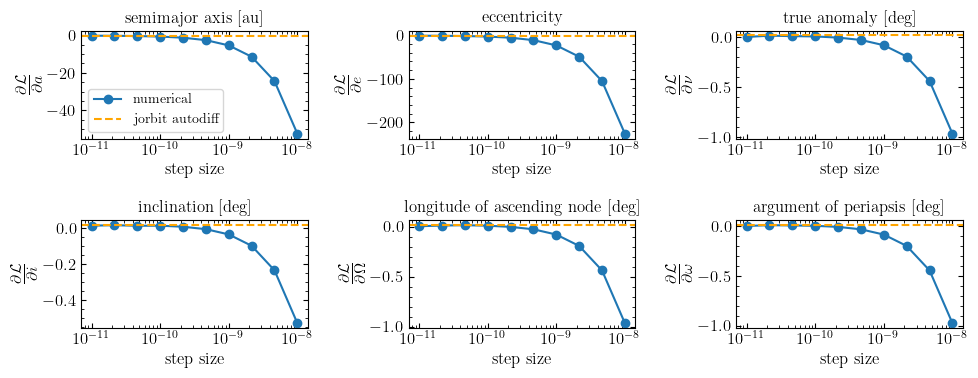

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 4))
for i, param in enumerate(["semi", "ecc", "nu", "inc", "Omega", "omega"]):
    ax = plt.subplot(2, 3, i + 1)
    ax.plot(
        10 ** jnp.linspace(-8, -11, 10),
        numerical_derivs[param],
        marker="o",
        label="numerical",
    )
    ax.axhline(
        autodiff_grads[param], color="orange", linestyle="--", label="jorbit autodiff"
    )
    ax.set_xscale("log")
    if i == 0: ax.legend(fontsize=10)

proper_names = [
    "semimajor axis [au]",
    "eccentricity",
    "true anomaly [deg]",
    "inclination [deg]",
    "longitude of ascending node [deg]",
    "argument of periapsis [deg]",
]
frac_names = [
    "a",
    "e",
    "\\nu",
    "i",
    "\\Omega",
    "\\omega",
]
for i, param in enumerate(["semi", "ecc", "nu", "inc", "Omega", "omega"]):
    ax = plt.subplot(2, 3, i + 1)
    ax.set_title(proper_names[i], fontsize=12)
    ax.tick_params(labelsize=12)
    ax.set_xlabel("step size", fontsize=12)
    l = "$\\frac{\\partial \\mathcal{L}}{\\partial " + frac_names[i] + "}$"
    ax.set_ylabel(l, fontsize=16)

plt.tight_layout()
# plt.savefig("figures/autodiff_vs_numerical.pdf", bbox_inches="tight")

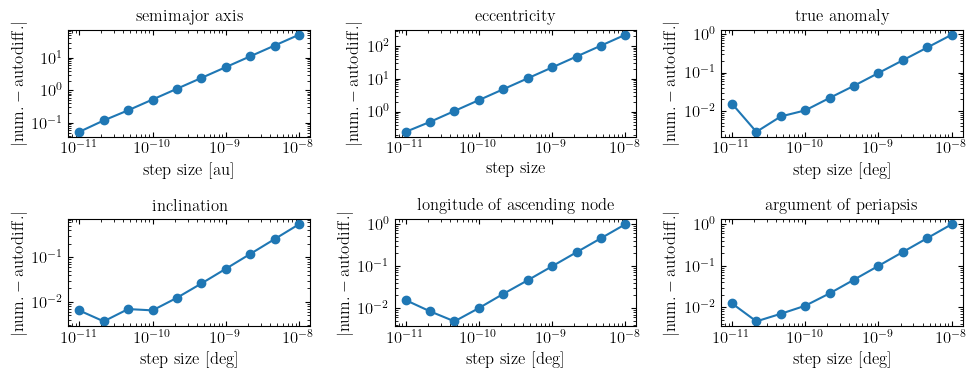

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 4))
for i, param in enumerate(["semi", "ecc", "nu", "inc", "Omega", "omega"]):
    ax = plt.subplot(2, 3, i + 1)
    ax.plot(
        10 ** jnp.linspace(-8, -11, 10),
        np.abs(numerical_derivs[param] - autodiff_grads[param]),
        marker="o",
        label="numerical",
    )
    # ax.axhline(
    #     autodiff_grads[param], color="orange", linestyle="--", label="jorbit autodiff"
    # )
    ax.set_xscale("log")
    ax.set_yscale("log")

proper_names = [
    "semimajor axis",
    "eccentricity",
    "true anomaly",
    "inclination",
    "longitude of ascending node",
    "argument of periapsis",
]
units = [
    "[au]",
    "",
    "[deg]",
    "[deg]",
    "[deg]",
    "[deg]",
]

# frac_names = [
#     "a",
#     "e",
#     "\\nu",
#     "i",
#     "\\Omega",
#     "\\omega",
# ]
for i, (name, unit) in enumerate(zip(proper_names, units)):
    ax = plt.subplot(2, 3, i + 1)
    ax.set_title(name, fontsize=12)
    ax.tick_params(labelsize=12)
    ax.set_xlabel(f"step size {unit}", fontsize=12)
    # l = "$\\frac{\\partial \\mathcal{L}}{\\partial " + frac_names[i] + "}$"
    # ax.set_ylabel(l, fontsize=16)
    ax.set_ylabel("$|\\mathrm{num.} - \\mathrm{autodiff.}|$", fontsize=12)

plt.tight_layout()
plt.savefig("figures/autodiff_vs_numerical.pdf", bbox_inches="tight")